In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm
import wandb

/var/folders/s6/ky9bs73s61s_hmchh70d7kqh0000gn/T/ipykernel_41491/3683815852.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
pd.options.display.max_rows = 150

In [3]:
api = wandb.Api(timeout=20)

In [4]:
filters = {
    "state": "finished"
}

# runs = api.runs("flow-graphs-cmu/flow_graphs-code", filters=filters)


## re-run risec and chemu
# sweeps = [
#     "zt62jnek", # RISEC multiseed, all. fewshot 1-10
#     "2fvdobq5", #  RISEC single seed, fewshot 1-10
#     "v57twc84", # RISEC AMR only, multiseed, fewshot 1-10
#     "cb3sa5r1", # Chemu multiseed, AMR only. fewshot 1-50. 
#     "d7163mab" # Chemu multiseed, all. fewshot 1-50
# ]

# from-scratch sweep
sweeps = ["xvhtni6a", "8x2k1pzw", "chq3l9ny"]


runs = []
for sweep_id in sweeps:
    sweep = api.sweep(f"flow-graphs-cmu/narrative-flow-simplified/{sweep_id}")
    runs.extend(sweep.runs)

In [5]:
df_dicts = []

for run in tqdm(runs):
    try:
        test_f1  = run.history(keys=["test_f1"], pandas=False)[0]["test_f1"]
        df_dicts.append({**run.config, "test_f1": test_f1})
    except:
        continue

results_df = pd.DataFrame(df_dicts)

100%|██████████| 270/270 [00:59<00:00,  4.54it/s]


In [6]:
results_df

,lr,gnn,case,seed,epochs,fewshot,patience,base_path,gnn_depth,batch_size,...,wandb_project,use_graph_data,checkpoint_folder,experiment_config,graph_data_source,graph_connection_type,grad_accumulation_steps,test_f1,train_dataset_instances,train_dataset_instance_hash
0,0.00002,rgcn,plaintext,0,30,0.50,5,/projects/flow_graphs,4,16,...,narrative-flow-simplified,False,/projects/flow_graphs/checkpoints,baseline,None,concat,1,0.872059,NaN,NaN
1,0.00002,rgcn,plaintext,0,30,0.10,5,/projects/flow_graphs,4,16,...,narrative-flow-simplified,False,/projects/flow_graphs/checkpoints,baseline,None,concat,1,0.799350,NaN,NaN
2,0.00002,rgcn,plaintext,0,30,0.10,5,/projects/flow_graphs,4,16,...,narrative-flow-simplified,False,/projects/flow_graphs/checkpoints,baseline,None,concat,1,0.662426,NaN,NaN
3,0.00002,rgcn,plaintext,2,30,0.05,5,/projects/flow_graphs,4,16,...,narrative-flow-simplified,False,/projects/flow_graphs/checkpoints,baseline,None,concat,1,0.479942,NaN,NaN
4,0.00002,rgcn,plaintext,0,30,0.05,5,/projects/flow_graphs,4,16,...,narrative-flow-simplified,False,/projects/flow_graphs/checkpoints,baseline,None,concat,1,0.656976,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.00002,rgcn,plaintext,2,30,0.01,5,/projects/flow_graphs,4,16,...,narrative-flow-simplified,False,/projects/flow_graphs/checkpoints,baseline,None,concat,1,0.154200,"[3535, 3477, 231, 375, 347, 1478, 3422, 692, 3...",2.186138e+18
266,0.00002,rgcn,plaintext,1,30,0.01,5,/projects/flow_graphs,4,16,...,narrative-flow-simplified,False,/projects/flow_graphs/checkpoints,baseline,None,concat,1,0.373925,"[2201, 9325, 13884, 13144, 12513, 1033, 4179, ...",6.948405e+18
267,0.00002,rgcn,plaintext,1,30,0.01,5,/projects/flow_graphs,4,16,...,narrative-flow-simplified,False,/projects/flow_graphs/checkpoints,baseline,None,concat,1,0.069457,"[550, 2331, 3471, 3286, 3128, 258, 1044, 482, ...",8.049769e+18
268,0.00002,rgcn,plaintext,0,30,0.01,5,/projects/flow_graphs,4,16,...,narrative-flow-simplified,False,/projects/flow_graphs/checkpoints,baseline,None,concat,1,0.302824,"[13835, 6311, 12418, 6890, 663, 4242, 8376, 79...",-4.828049e+18


In [7]:
dataset_name_mapping = {
    "risec": "RISeC",
    "japflow": "English Flow Graphs",
    "chemu": "Chemical Patents",
    "mscorpus": "Materials Science",
}

In [8]:
results_df.shape

(270, 27)

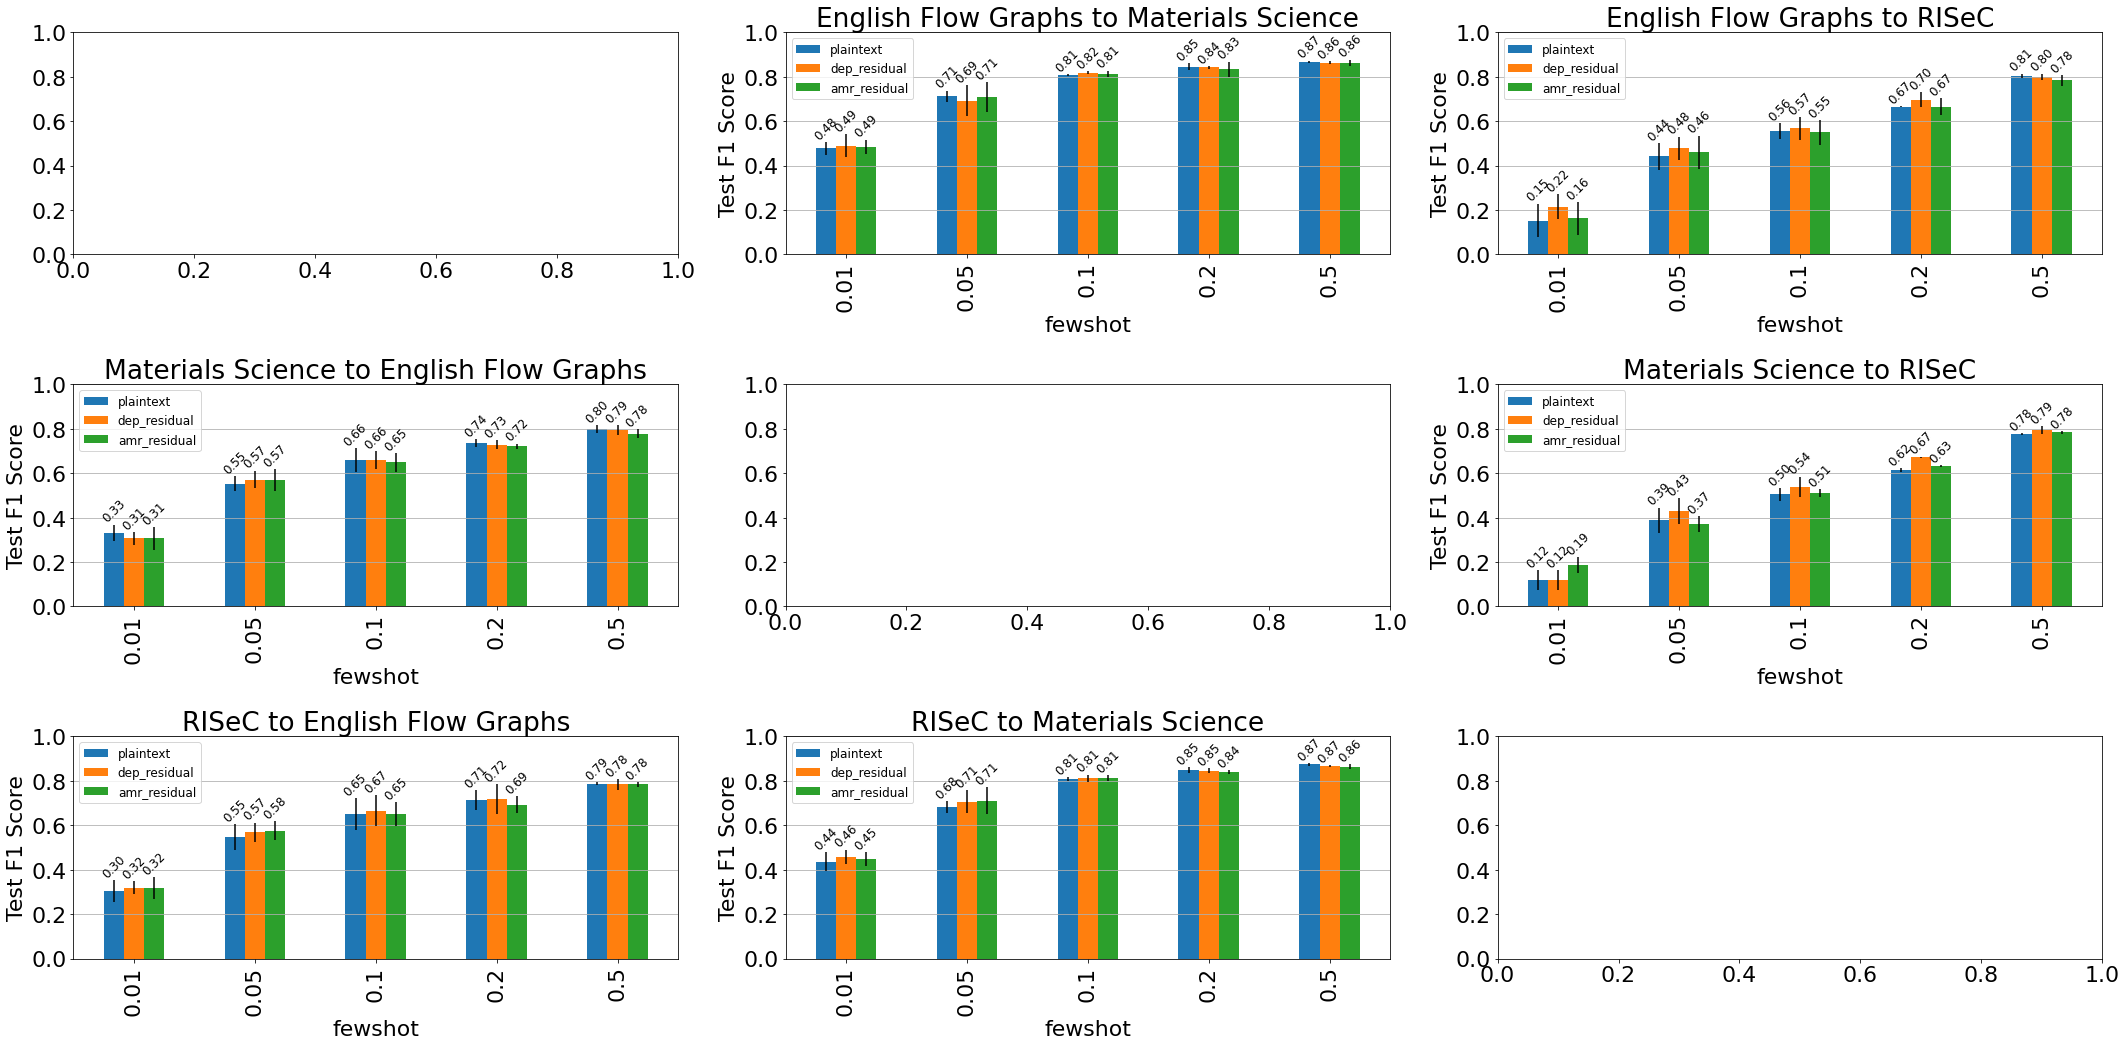

In [27]:
matplotlib.rcParams.update({'font.size': 22})

src_datasets = set(results_df["src_dataset"])
tgt_datasets = set(results_df["tgt_dataset"])

fig, axes = plt.subplots(len(tgt_datasets),len(src_datasets), figsize=(len(src_datasets) * 10, len(tgt_datasets) * 5), tight_layout=True)
ax_iter = iter(axes.reshape([-1]))

for src_dataset in sorted(src_datasets):
    for i, tgt_dataset in enumerate(sorted(tgt_datasets)):
        ax = next(ax_iter)

        ax.set_title(f"{dataset_name_mapping[src_dataset]} to {dataset_name_mapping[tgt_dataset]}")
        ax.set_ylim(0, 1)
        ax.set_xlabel("Fewshot Setting")
        ax.set_ylabel("Test F1 Score")
        if src_dataset == tgt_dataset:
            continue
        results_viz = results_df[(results_df["src_dataset"] == src_dataset) & (results_df["tgt_dataset"] == tgt_dataset)].groupby(["fewshot", "case"])["test_f1"].aggregate(["mean", "std"]).unstack(1)       
        graph = results_viz["mean"][["plaintext", "dep_residual", "amr_residual"]].plot.bar(ax=ax, yerr=results_viz["std"])
        graph.grid(axis="y", which="both")

        ax.legend(fontsize=12)


        for bars in ax.containers:
            try:
                ax.bar_label(bars, fmt="%2.2f", rotation=45, fontsize=12)
            except:
                pass


In [10]:
unstacked = results_df.groupby(["tgt_dataset", "fewshot", "seed", "case"])["test_f1"].mean().unstack(-1)
unstacked

case                      amr_residual  dep_residual  plaintext
tgt_dataset fewshot seed                                       
japflow     0.01    0         0.310130      0.316285   0.296662
                    1         0.363508      0.338757   0.365943
                    2         0.263151      0.284150   0.289538
            0.05    0         0.570229      0.564407   0.559350
                    1         0.619466      0.613546   0.588607
                    2         0.528271      0.533422   0.499901
            0.10    0         0.676071      0.704859   0.676659
                    1         0.677651      0.682375   0.702845
                    2         0.595371      0.599552   0.584705
            0.20    0         0.731710      0.760242   0.748990
                    1         0.708593      0.722127   0.735854
                    2         0.681264      0.686876   0.688583
            0.50    0         0.783835      0.813112   0.806303
                    1         0.794886      0.784538   0.788463
                    2         0.764588      0.769226   0.783781
mscorpus    0.01    0         0.443279      0.438527   0.439679
                    1         0.497041      0.501320   0.497989
                    2         0.461680      0.481370   0.432289
            0.05    0         0.640291      0.636906   0.671552
                    1         0.723989      0.701839   0.723891
                    2         0.764441      0.759017   0.695877
            0.10    0         0.802287      0.810559   0.801882
                    1         0.810350      0.804889   0.812371
                    2         0.828282      0.828969   0.811320
            0.20    0         0.851272      0.852043   0.860748
                    1         0.846901      0.841863   0.846104
                    2         0.811509      0.839975   0.833388
            0.50    0         0.878077      0.869387   0.872247
                    1         0.860247      0.858866   0.875229
                    2         0.851057      0.868938   0.865427
risec       0.01    0         0.213100      0.188708   0.178249
                    1         0.158321      0.160110   0.070364
                    2         0.149708      0.153094   0.159410
            0.05    0         0.469912      0.489717   0.481247
                    1         0.360392      0.391385   0.383845
                    2         0.417861      0.481725   0.381626
            0.10    0         0.552117      0.542842   0.558773
                    1         0.490111      0.509669   0.497818
                    2         0.549972      0.605658   0.534877
            0.20    0         0.669554      0.696457   0.644597
                    1         0.627856      0.665750   0.639729
                    2         0.649914      0.691453   0.637090
            0.50    0         0.792846      0.779792   0.794672
                    1         0.773053      0.800172   0.786691
                    2         0.786223      0.810207   0.789402

<AxesSubplot:>

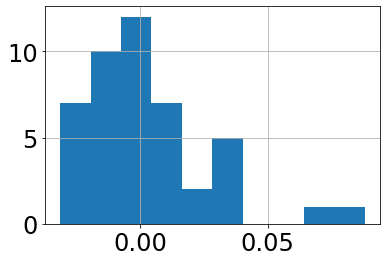

In [11]:
(unstacked["amr_residual"] - unstacked["plaintext"]).hist()

<AxesSubplot:>

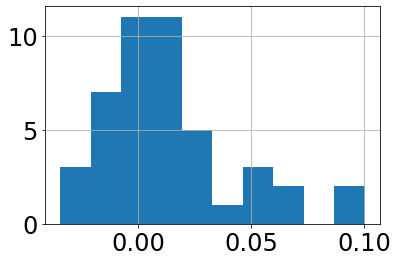

In [12]:
(unstacked["dep_residual"] - unstacked["plaintext"]).hist()